# Thoracic Surgery Life Expectancy Classification

In [235]:
%%capture
!pip install seaborn
!pip install xgboost
!pip install dexplot

In [259]:
# loading dataset
from scipy.io import arff
import urllib.request
from io import StringIO
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import dexplot as dxp

# pre-processing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# parameter tuning
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import confusion_matrix, classification_report

rs = 1

## Loading the Dataset

In [5]:
data = arff.loadarff('data/ThoraricSurgery.arff')
df = pd.DataFrame(data[0])
str_df = df.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()

In [6]:

# download dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00277/ThoraricSurgery.arff"
ftpstream = urllib.request.urlopen(url)
data, meta = arff.loadarff(StringIO(ftpstream.read().decode('utf-8')))
df = pd.DataFrame(data)

# strip vaues according to utf-8 encoding 
df = df.select_dtypes([np.object])
df = df.stack().str.decode('utf-8').unstack()

In [179]:
df.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T


## Preprocessing

### Check that there are no missing values.

In [97]:
desc = df.describe() # saving it to use it during visualisation
desc

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
count,470,470,470,470,470,470,470,470,470,470,470,470,470,470
unique,7,3,2,2,2,2,2,4,2,2,2,2,2,2
top,DGN3,PRZ1,F,F,F,T,F,OC12,F,F,F,T,F,F
freq,349,313,439,402,439,323,392,257,435,468,462,386,468,400


In [9]:
df.notnull().describe()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
count,470,470,470,470,470,470,470,470,470,470,470,470,470,470
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,True,True,True,True,True,True,True,True,True,True,True,True,True,True
freq,470,470,470,470,470,470,470,470,470,470,470,470,470,470


### Visualise data

In [178]:
df_surv = df.loc[df["Risk1Yr"] == 'F']
df_died = df.loc[df["Risk1Yr"] == 'T']

features = dict(DGN =   'Diagnosis',
        #PRE4 =	'Forced vital capacity',
        #PRE5 =	'Volume that has been exhaled at the end of the first second of forced expiration',
        PRE6 =	'Performance status - Zubrod scale',
        PRE7 =	'Pain before surgery',
        PRE8 =  'Haemoptysis before surgery',
        PRE9 =	'Dyspnoea before surgery',
        PRE10 =	'Cough before surgery',
        PRE11 = 'Weakness before surgery',
        PRE14 = 'size of the original tumour',
        PRE17 = 'Type 2 DM - diabetes mellitus',
        PRE19 = 'MI up to 6 months',
        PRE25 = 'PAD - peripheral arterial diseases',
        PRE30 = 'Smoking',
        PRE32 = 'Asthma',
        #AGE =   'Age at surgery'
        )

In [48]:
df_surv.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F
5,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,F,F,F


fig = plt.figure(1, figsize=(20.0,20.0))
c = 0
plt.style.use('seaborn-deep')

for k,v in features.items():
    c += 1
    val = list(desc[k])[1] # possible values for each column
    chart = fig.add_subplot(5,5,c)
    chart.title.set_text(v)
    
    bins = np.linspace(0, val, num=val+1)

    surv = df_surv[k]
    died = df_died[k]

    chart.hist(surv , bins, alpha=1, color='pink', label='survived', rwidth=6)
    chart.hist(died , bins, alpha=0.1, color='blue', label='died', rwidth=6)

    plt.legend(loc='upper right')

plt.show()

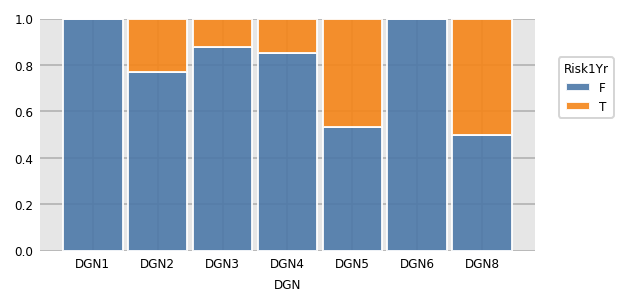

In [267]:
feat = list(df.columns)[0] # change index number to observe fatality of other features
dxp.count(val=feat, data=df, split='Risk1Yr',
          normalize=[feat], stacked=True)
# yellow = died    blue = survived

In [186]:
df.shape

(470, 14)

In [189]:
target = df.Risk1Yr
target.shape

(470,)

In [194]:
labels = np.reshape(target.values,(470,1))
labels.shape

(470, 1)

In [199]:
pca_data = np.concatenate(df, axis=1)
pca_data.shape

(470, 15)

In [202]:
ds = pd.DataFrame(pca_data)
ds.head

<bound method NDFrame.head of        0     1  2  3  4  5  6     7  8  9  10 11 12 13 14
0    DGN2  PRZ1  F  F  F  T  T  OC14  F  F  F  T  F  F  F
1    DGN3  PRZ0  F  F  F  F  F  OC12  F  F  F  T  F  F  F
2    DGN3  PRZ1  F  F  F  T  F  OC11  F  F  F  T  F  F  F
3    DGN3  PRZ0  F  F  F  F  F  OC11  F  F  F  F  F  F  F
4    DGN3  PRZ2  F  T  F  T  T  OC11  F  F  F  T  F  T  T
..    ...   ... .. .. .. .. ..   ... .. .. .. .. .. .. ..
465  DGN2  PRZ1  F  F  F  T  F  OC13  F  F  F  T  F  F  F
466  DGN3  PRZ0  F  F  F  F  F  OC11  F  F  F  T  F  F  F
467  DGN3  PRZ1  F  F  F  T  F  OC13  F  F  F  F  F  F  F
468  DGN3  PRZ1  F  F  F  T  T  OC12  F  F  F  T  F  F  F
469  DGN3  PRZ0  F  F  F  F  F  OC12  F  F  F  T  F  F  F

[470 rows x 15 columns]>

In [208]:
ds.columns = ['DGN', 'PRE6', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE14', 'PRE17', 'PRE19', 'PRE25', 'PRE30', 'PRE32', 'Risk1Yr', 'label']
ds.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr,label
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F,F
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F,F
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F,F
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F,F
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T,T


In [213]:
ds['label'].replace('F', 'Survived',inplace=True)
ds['label'].replace('T', 'Died',inplace=True)
ds.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr,label
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F,Survived
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F,Survived
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F,Survived
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F,Survived
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T,Died


,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr,label
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F,Survived
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F,Survived
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F,Survived
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F,Survived
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T,Died


In [245]:
ohe = OneHotEncoder()
ds_e = pd.DataFrame(ohe.fit_transform(ds.to_numpy()).toarray())
ds_e.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


In [242]:
sum(ds.describe().iloc[1,]) # to check the possible feature values correspond to the number of columns

38

### Shuffle and split data into features X and target y.

In [262]:
ds_er = ds_e.sample(frac=1)

X = ds_er.iloc[:,:-2]
y = ds_er.iloc[:,-1]

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
432,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
423,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
463,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
154,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
348,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


## Algorithm

In [263]:
# splitting train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [264]:
models = [LogisticRegression(random_state=rs),
          MultinomialNB(),
          KNeighborsClassifier(),
          SVC(random_state=rs),
          LinearSVC(random_state=rs),
          DecisionTreeClassifier(random_state=rs),
          RandomForestClassifier(random_state=rs),
          GradientBoostingClassifier(random_state=rs),
          XGBClassifier(random_state=rs)]

model = []
mean = []
std = []
mins = []
maxs = []

for model in models:
    cross = cross_val_score(clf, X_train, y_train, cv=5)
    model.append(type(model).__name__)
    mean.append(cross.mean())
    std.append(cross.std())
    mins.append(min(cross))
    maxs.append(max(cross))

result = pd.DataFrame({"Model":model, "Acc. mean":mean, "STD":std, "min":mins, "max":maxs})
result

[10:03:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:03:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:03:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:03:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,Model,Acc. mean,STD,min,max
0,LogisticRegression,1.000000,0.000000,1.000000,1.000000
1,MultinomialNB,1.000000,0.000000,1.000000,1.000000
2,KNeighborsClassifier,0.945268,0.015529,0.924242,0.969697
3,SVC,1.000000,0.000000,1.000000,1.000000
4,LinearSVC,1.000000,0.000000,1.000000,1.000000
5,DecisionTreeClassifier,1.000000,0.000000,1.000000,1.000000
6,RandomForestClassifier,1.000000,0.000000,1.000000,1.000000
7,GradientBoostingClassifier,1.000000,0.000000,1.000000,1.000000
8,XGBClassifier,1.000000,0.000000,1.000000,1.000000
